# Exciton-Polaritons in Lattices

**by Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

Python code to simulate exciton-polaritons in lattices.

# 1. Far-field emission from a polaritonic lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import exp2d # my module
import imp
#imp.reload(exp2d) # reload exp2d after update

## 1.1 Model

In [3]:
### Physical parameters
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
Lconstant = 5.8 # lattice constant, micron
Rpillar = 1.5 # pillar radius, micron
UinmeV=0.-0.1*1j # meV
UoutmeV=10-0.5*1j # meV

In [4]:
### Numerical calculation parameters
M=20 # discretization, even number
Nbands=10 # number of bands to calculate
NBzones=4 # number of Brillouion zones to calculate

In [5]:
assert M%2==0
Mhalf=round(M/2)
hbar=1.05e-34 # reduced Planck constant, J s
E0=hbar*hbar/(2.*meff*Lconstant*Lconstant*1.e-12)/(1.6e-22) # characteristic energy, meV
dr=1./M
dr2=dr*dr

In [6]:
### Define potential in one unit cell
U = exp2d.U_Lieb(M, Rpillar/Lconstant, UinmeV/E0, UoutmeV/E0)

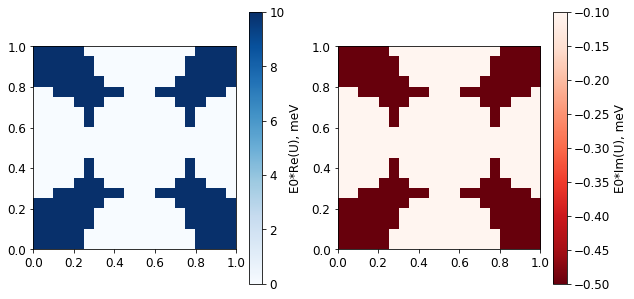

In [7]:
### Display potential
plt.rc('font', size=12)
fig,ax=plt.subplots(1,2,figsize=(10,5))
img0=ax[0].imshow(E0*U.real.T,cmap = plt.cm.Blues, extent=[0,1,0,1], origin='lower')
img1=ax[1].imshow(E0*U.imag.T,cmap = plt.cm.Reds_r, extent=[0,1,0,1], origin='lower')
plt.colorbar(img0,ax=ax[0],label='E0*Re(U), meV')
plt.colorbar(img1,ax=ax[1],label='E0*Im(U), meV')
plt.show()

## 1.2 Bloch states and band structure 

$$
-\Delta \psi_{n,\mathbf{k}}(\mathbf{r}) + \Re[U(x,y)] \,\psi_{n,\mathbf{k}}(\mathbf{r}) = E_n \psi_{n,\mathbf{k}}(\mathbf{r}),
$$

In [8]:
### Calculate band structure at ky=0.
kxrange = np.linspace(-np.pi,np.pi,30)
kyrange=np.array([0.])
%time evalsarr,evecsarr = exp2d.eigsystem(M, U, kxrange, kyrange, Nbands)

CPU times: user 619 ms, sys: 4.31 ms, total: 624 ms
Wall time: 315 ms


Text(0,0.5,'$E, \\rm meV$')

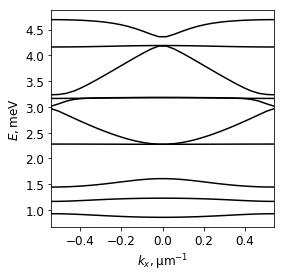

In [9]:
### Display the band structure
plt.rc('font', size=12)
fig,ax = plt.subplots(figsize=(4,4))
for i in range(Nbands):
    ax.plot(kxrange/Lconstant,E0*evalsarr[0][:,i],'k')  
ax.set_xlim([kxrange[0]/Lconstant,kxrange[-1]/Lconstant])
ax.set_xlabel(r"$k_x, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")

In [10]:
### Calculate Bloch states at (kx,ky)=(0,0)
kxrange=np.array([0.])
kyrange=np.array([0.])
%time evalsarr,evecsarr = exp2d.eigsystem(M, U, kxrange, kyrange, Nbands)

CPU times: user 46.4 ms, sys: 65 µs, total: 46.4 ms
Wall time: 35.3 ms


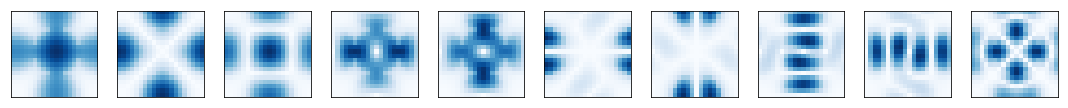

In [11]:
### Display Bloch states' probability density
fig, ax = plt.subplots(1,Nbands,figsize=(15,2))
for nv in range(Nbands):
    data=np.abs(evecsarr[0,0][nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = plt.cm.Blues, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])
plt.tight_layout()
plt.show()

## 1.3 Time evolution from a random initial state

$$
i\frac{\partial\psi}{\partial t} = -\Delta \psi + \Re[U(x,y)]\,\psi + i\Im[U(x,y)]\,\psi, \quad \psi(\mathbf{r},0)=\psi_0(\mathbf{r})
$$

In [12]:
Ncells=8 # 12, integer number for symmetric display
Nframes=80 # 200
Nsamples=5 # 40
Emin=0.5
Emax=5.2
dt=0.002 # timestep
kylist = np.array([0., np.pi/2., np.pi, 3.*np.pi/2.]);
Length=1.0*Ncells # length of the domain

In [13]:
# Define potential in a supercell of Ncells x Ncells cells
Mglobal=Ncells*M
Uglobal=np.zeros((Mglobal,Mglobal),dtype=np.complex128)
for i in range(Ncells):
    for j in range(Ncells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = np.copy(U[:,:])

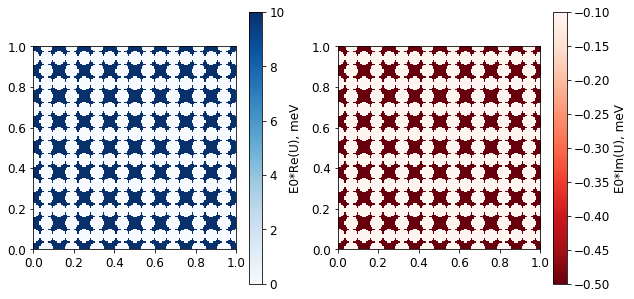

In [14]:
### Display potential
plt.rc('font', size=12)
fig,ax=plt.subplots(1,2,figsize=(10,5))
img0=ax[0].imshow(E0*Uglobal.real.T,cmap = plt.cm.Blues, extent=[0,1,0,1], origin='lower')
img1=ax[1].imshow(E0*Uglobal.imag.T,cmap = plt.cm.Reds_r, extent=[0,1,0,1], origin='lower')
plt.colorbar(img0,ax=ax[0],label='E0*Re(U), meV')
plt.colorbar(img1,ax=ax[1],label='E0*Im(U), meV')
plt.show()

In [15]:
dkx=2.*np.pi/Ncells
kmax=NBzones*np.pi
dtout = np.pi*E0/Emax # from the Nyquist frequency at Emax
countout=int(dtout/dt)
dE=2.*np.pi*E0/(Nframes*countout*dt)
krange = -np.pi + dkx*np.arange(Ncells) # over the BZ  

In [16]:
# %time evalsarr,evecsarr = exp2d.eigsystem(M, U, krange, krange, Nbands)

In [17]:
# from numpy.ctypeslib import ndpointer, load_library
# from ctypes import *

# ### === C library interface ===
# libcd = load_library("liblattice.so", ".")
# libcd.evolve.restype = None
# libcd.evolve.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
#         ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
#         c_double, c_int, c_double, c_int, c_int,
#         ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
#         ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),  c_int]

# # set number of OpenMP threads
# libcd.omp_set_num_threads(2)

# FPsiarr=np.empty((Nframes,len(kylist),Mglobal),dtype=np.complex128)

# probsum=np.zeros((len(kylist),round(Emax/dE)-round(Emin/dE),
#                   1+int(Mglobal*0.5+kmax/dkx)-int(Mglobal*0.5-kmax/dkx)), dtype=np.float64)

# for sample in range(Nsamples):

#     Psi=np.zeros((Mglobal,Mglobal),dtype=np.complex128)

#     # Loop over BZ
#     for n in range(Ncells):
#         ky=-np.pi+n*dkx
#         for m in range(Ncells):
#             kx=-np.pi+m*dkx
#             for nv in range(Nbands):

#                 psi=np.copy(evecsarr[n,m,nv].reshape(M,M))

#                 randphase = np.exp(1j*2.*np.pi*np.random.random_sample())
#                 for i in range(Ncells):
#                     for j in range(Ncells):
#                         Psi[i*M:(i+1)*M,j*M:(j+1)*M] += randphase*psi[:,:]*np.exp(1j*(kx*i+ky*j))

#     libcd.evolve(Psi,FPsiarr,Length,M*Ncells,dt,Nframes,countout,Uglobal,kylist,kylist.size)
    
#     for Pky in range(len(kylist)):
#         fftarr=np.fft.fftshift(np.fft.fft(FPsiarr[:,Pky,:],axis=0),axes=1)
#         data=(fftarr*np.conjugate(fftarr)).real
#         data1=data[::-1]
#         data2=data1[round(Emin/dE):round(Emax/dE),int(Mglobal*0.5-kmax/dkx):int(Mglobal*0.5+kmax/dkx)+1]
#         probsum[Pky,:,:] += data2
        
#     print("# Sample %d: done" % sample)     

In [18]:
# plt.rc('font', family='serif')
# plt.rc('font', size='18')
# fig, ax = plt.subplots(1, len(kylist), figsize=(14,5))

# ### Display the expected far field intensity
# for Pky in range(len(kylist)):
#     i=Pky
#     img=ax[i].imshow(probsum[Pky],aspect='auto', interpolation='gaussian', 
#                      extent=[-kmax/Lconstant,kmax/Lconstant,Emin,Emax], cmap = exp2d.mycmap, origin='lower')
#     ax[i].set_xlabel(r'$k_x,\;\mu m^{-1}$')
#     ax[i].set_xticks([-2,-1,0,1,2])
#     ax[i].set_title(r'$k_y=%.2f\rm\; \mu m^{-1}$'%(kylist[Pky]/Lconstant), fontsize=18)
#     #plt.colorbar(img,ax=ax[i])
# ax[0].set_ylabel(r'$E,\;\rm meV$')

# ### Overlay the band structure
# kxrange = np.concatenate(([2.*np.pi*n + krange for n in np.arange(-int(NBzones/2),1+int(NBzones/2))]))
# for Pky in range(len(kylist)):
#     nax=Pky
#     ky = kylist[Pky] # normalized
#     kyind = int(round((np.pi+kylist[Pky])/dkx))%Ncells
#     evlist=evalsarr[kyind]
#     for i in range(Nbands):
#         evrange = np.concatenate(([evlist[:,i] for n in np.arange(-int(NBzones/2),1+int(NBzones/2))]))
#         ax[nax].plot(kxrange/Lconstant,E0*evrange,'k')  
#     ax[nax].set_xlim([-kmax/Lconstant,kmax/Lconstant])
#     ax[nax].set_ylim([Emin,Emax])
#     ax[nax].set_xlabel(r"$k_x, \rm \mu m^{-1}$")
#     ax[nax].set_ylabel(r"$E, \rm meV$")

# plt.tight_layout()
# plt.show()

# With TE-TM

In [ ]:

exec(open('udefine.py').read())

#NBzones=1
Nvals=30
Nkpoints=50
M2=Mx*My
ky=0.
#kxrange=linspace(-NBzones*pi/Lcell, NBzones*pi/Lcell,Nkpoints)

Xpoint = np.array([pi/Lcell,0.])
Mpoint = np.array([pi/Lcell,pi/Lcell])

GXvector = np.array([pi/Lcell,0.])
XMvector = np.array([0.,pi/Lcell])
MGvector = np.array([-pi/Lcell,-pi/Lcell])

print('# beta0: %f' % (beta0))
print('# Omega: %f' % (Omega))

### Constructing matrix
start_time = time.time()
evlist=[]

kparrange=linspace(0,1,Nkpoints)

for kpar in kparrange:
#    kx,ky = kpar*GXvector
#    kx,ky = Xpoint + kpar*XMvector
    kx,ky = Mpoint + kpar*MGvector

    ekx=np.exp(-1j*kx*Lcell)
    eky=np.exp(-1j*ky*Lcell)

    # 2x2 matrices
    id1=np.array([[1,0],[0,1]])
    A=np.array([[-1,-beta0],[-beta0,-1]])
    B=np.array([[0,-1j*beta0/2.],[1j*beta0/2.,0]])
    C=np.array([[-1,beta0],[beta0,-1]])
    
    # Block AA
    data = concatenate(( 
        np.array([A,A*eky]),
        np.array([A]*2*(My-2)), 
        np.array([A*np.conjugate(eky),A]) ), axis=0)
    indices = np.concatenate(( 
        np.array([1, My-1]),
        np.array([[0+x,2+x] for x in range(My-2)]).ravel(),
        np.array([0, My-2]) ))
    indptr = np.arange(0,2*My+2,2)
    AA=bsr_matrix((data, indices, indptr), shape=(2*My, 2*My)).todense()
        
    # Block BB
    diagblock=np.stack(( 
        [B.T]*(My-2), 
        [C]*(My-2), 
        [B]*(My-2) ), axis=1).reshape(3*(My-2),2,2)
    data = concatenate(( 
        np.array([C,B,B.T*eky]),
        diagblock, 
        np.array([B*np.conjugate(eky),B.T,C]) ), axis=0)
    indices = np.concatenate(( 
        np.array([0, 1, My-1]),
        np.array([[0+x,1+x,2+x] for x in range(My-2)]).ravel(),
        np.array([0, My-2, My-1]) ))
    indptr = np.arange(0,3*My+3,3)
    BB=bsr_matrix((data, indices, indptr), shape=(2*My, 2*My)).todense()
    
    # Large matrix
    diagblock=np.stack(( 
        [BB.H]*(Mx-2), 
        [AA]*(Mx-2), 
        [BB]*(Mx-2) ), axis=1).reshape(3*(Mx-2),2*My,2*My)
    data = concatenate(( 
        np.array([AA,BB,BB.H*ekx]),
        diagblock, 
        np.array([BB*np.conjugate(ekx),BB.H,AA]) ), axis=0)
    indices = np.concatenate(( 
        np.array([0, 1, Mx-1]),
        np.array([[0+x,1+x,2+x] for x in range(Mx-2)]).ravel(),
        np.array([0, Mx-2, Mx-1]) ))
    indptr = np.arange(0,3*Mx+3,3)
    Matrix=bsr_matrix((data, indices, indptr), shape=(2*M2, 2*M2))
    
    # Add diagonal
    diag=dia_matrix(( 4.+dr2*U.ravel().repeat(2) ,0),shape=(2*M2,2*M2))
    Omegadiag = dia_matrix(([dr2*Omega,-dr2*Omega]*M2,0),shape=(2*M2,2*M2)) ### Zeeman splitting
    Matrix += diag + Omegadiag
    Matrix_CSC=Matrix.tocsc() ### can be improved by constructing CSC

    evalsunsorted=eigsh(Matrix_CSC, return_eigenvectors=False, k=Nvals, sigma=0)
    evalsunsorted/=dr2
    inds=argsort(evalsunsorted)
    evals=evalsunsorted[inds]
    evlist.append(evals)

evlist=np.array(evlist)

#np.savez('GXdata',kparrange=kparrange,evlist=evlist)
#np.savez('XMdata',kparrange=kparrange,evlist=evlist)
np.savez('MGdata',kparrange=kparrange,evlist=evlist)


# Nonlinear dynamics under drive

$$
i\frac{\partial\psi_{+}}{\partial t} = -\Delta \psi_{+} + \Re[U(x,y)]\,\psi_{+} + i \Im[U(x,y)]\,\psi_{+} 
+ \beta \left(\partial_x - i \partial_y\right)^2 \psi_{-} + \left(|\psi_{+}|^2+\alpha|\psi_{-}|^2\right)\psi_+
+ \Omega\psi_+ + A_{+}e^{-i\omega t},
\\
i\frac{\partial\psi_{-}}{\partial t} = -\Delta \psi_{-} + \Re[U(x,y)]\,\psi_{-} + i \Im[U(x,y)]\,\psi_{-} 
+ \beta \left(\partial_x + i \partial_y\right)^2 \psi_{+} + \left(|\psi_{-}|^2+\alpha|\psi_{+}|^2\right)\psi_-
- \Omega\psi_- + A_{-}e^{-i\omega t},
$$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import exp2d # my module
import imp
#imp.reload(exp2d) # reload exp2d after update
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *
from IPython.display import HTML

In [2]:
### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.lattice.restype = None
libcd.lattice.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
                          ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'),
                          ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'), 
                          ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
                          c_double, c_double, c_int, c_int, c_double, c_int, c_int, 
                          ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'),
                          c_double, c_double, c_double, c_double, c_double, c_double, c_double, 
                          c_int, c_int]

In [ ]:
### Define unit cell potential: Lieb lattice
# Lconstant = 5.8 # lattice constant, micron
# Rpillar = 1.5 # pillar radius, micron
# UinmeV=0.-0.1*1j # meV
# UoutmeV=10-0.5*1j # meV
# U = exp2d.U_Lieb(M, Rpillar/Lconstant, UinmeV/E0, UoutmeV/E0)

In [286]:
### Define unit cell potential: square lattice
Lconstant = 5.0 # lattice constant, micron
Rpillar = 2.5 # pillar radius, micron
UinmeV=0.-0.1*1j # meV
UoutmeV=10-0.5*1j # meV
U = exp2d.U_Square(M, Rpillar/Lconstant, UinmeV/E0, UoutmeV/E0)

In [287]:
### Polariton parameters
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
aratio=-0.05 # nonlinearity parameter $\alpha$
beta0=0.2 # TE-TM splitting parameter
Omega=0.0 # Magnetic field
hbar=1.05e-34 # reduced Planck constant, J s
E0=hbar*hbar/(2.*meff*Lconstant*Lconstant*1.e-12)/(1.6e-22) # characteristic energy, meV

In [360]:
### Simulation parameters
M=20 # discretization of one unit cell (MxM)
Nxcells=7 # number of units cells along x
Nycells=7 # number of units cells along y
MNx=M*Nxcells
MNy=M*Nycells
Lx=1.0*Nxcells # length of the domain along x in units of lattice constant
Ly=1.0*Nycells # length of the domain along y in units of lattice constant
dt=0.0005 # simulation timestep, should be << 1/U
dtout=0.02 # output timestep
Nframes=30 # number of frames

In [361]:
### Parameters of the pump
Rspot = 2.0 # radius of the Gaussian pump spot
i0=int(MNx/2) # location of the spot (node index along x)
j0=int(MNy/2) # location of the spot (node index along y)
A1amp=130. # drive amplitude for psi_plus component
A2amp=130. # drive amplitude for psi_minus component 
Edrive = 2.0 # pump frequency in meV
omegadrive=Edrive/E0
countout=int(dtout/dt)

In [362]:
### Define supercell potential
Uglobal=np.zeros((MNx,MNy),dtype=np.complex128)
for i in range(Nxcells):
    for j in range(Nycells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = np.copy(U[:,:])    

In [363]:
### Initialization
Psi1=np.zeros((MNx,MNy),dtype=np.complex128)
Psi2=np.zeros((MNx,MNy),dtype=np.complex128)
Psi1data=np.empty((Nframes,MNx,MNy),dtype=np.complex128)
Psi2data=np.empty((Nframes,MNx,MNy),dtype=np.complex128)

In [364]:
### Calculation using the compiled C modules
libcd.lattice(Psi1,Psi2,Psi1data,Psi2data,Lx,Ly,MNx,MNy,dt,Nframes,countout,Uglobal,
              aratio,beta0,Omega,A1amp,A2amp,omegadrive,Rspot,i0,j0)

In [369]:
### Display the last frame
#exp2d.cpsi12(Psi1data[-1],Psi2data[-1],interpolation='gaussian')

In [366]:
### Create animation
anim=exp2d.vipsi12(Psi1data,Psi2data,interpolation='gaussian')

In [367]:
### Display animation
HTML(anim.to_html5_video())

In [368]:
### Save animation to file
anim.save('square.mp4', writer = 'ffmpeg', fps=15)